# Overfitting

... Normally? A bad thing! But for our case it's good...

We use a new method to mix an overfitted model (our own) with a pretrained model (GPT-Neo-125M) and have them share eachothers traits. This way it's possible to finetune a model without having to retrain it. It's so fast it can be done in a second on CPU.

In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import content_aware_encode, train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, visualize_lr
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 970988852
#seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 970988852


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    'lr': 1e-4,
    "warmup_factor": 5,
    'scheduler': 'cycles_buildoff',
    "cycles": 100,
    "lr_end": 1e-6,
    "power": 0.6,
    #"freeze_from_steps": -1,
    'freeze_once': True,
    'freeze_layer_rate': 1e-4 * 0.05,
    'to_freeze_count': 150,
    "seed": seed,
    "num_epoch": 1000
}

# Show me your LR!

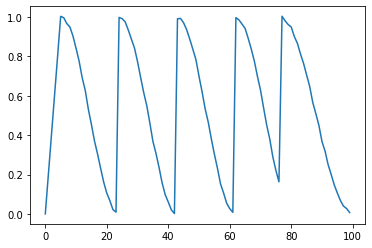

In [5]:
visualize_lr(config)

In [6]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained(Config.base_model_name)
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model(Config.base_model_name)
    print("Loaded empty model")
model = model.to(device)
print(f"{Config.base_model_name} loaded with {len(list(model.named_parameters()))} params...")
# set_pretrained_model_dropout(model.transformer.h, 0.0005)

Downloading: 100%|██████████| 560/560 [00:00<00:00, 416kB/s]
Downloading: 100%|██████████| 0.98k/0.98k [00:00<00:00, 809kB/s]
Downloading: 100%|██████████| 878k/878k [00:00<00:00, 1.29MB/s]
Downloading: 100%|██████████| 446k/446k [00:00<00:00, 1.02MB/s]
Downloading: 100%|██████████| 357/357 [00:00<00:00, 271kB/s]
Downloading: 100%|██████████| 502M/502M [01:43<00:00, 5.09MB/s] 
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Loaded empty model
EleutherAI/gpt-neo-125M loaded with 160 params...


# Test before training on a pretrained model!

In [7]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon in the dark. I'm a dragon in the dark.

A few months ago, I was in the middle of a storm and was running into a thunderstorm. The storm had hit a house in the town, and I was getting ready to throw up and walk home. I saw the sign that read "Dress in a Dark Dress." It said "Tear the Fire" and I turned to look.

"Oh my God," I said, "that was so bad."

I went to the bathroom, got dressed and went to the kitchen. I looked at


# Reviewing our dataset!

In [8]:
dataset = get_dataset(seed, tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
with open("data_train_sample.txt", 'w') as f:
    for i, item in enumerate(dataset['train']):
        f.write(tokenizer.decode(item['input_ids']) + "\n")
        
with open("data_train_sample2.txt", 'w') as f:
    for i, item in enumerate(dataset['train']):
        f.write(tokenizer.decode(item['input_ids']) + "\n")
        
print("RP review!")
to_see_rp = [
    'c "Fight',
    'c "What do you think of Lorem?'
]
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    for rp in list(to_see_rp):
        if rp in decoded: 
            print(decoded)
            print("-" * 10)
            to_see_rp.remove(rp)
            continue
    if len(to_see_rp) == 0:
        break
# Clean up
del to_see_rp

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 394.94it/s]


Dataset text downloaded and prepared to /home/awsw-dev/.cache/huggingface/datasets/text/default-b141815bda7250ea/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 425.84it/s]


RP review!
<d><scn>eckswimmingpool<msg>Nm smile "...Yeah."<p><msg>c "Fight"<d><scn>eckswimmingpool<msg>m "Naomi barely avoids my attack and fell, but managed to get up and quickly punch me in the face, a soaring pain quickly came over my face"<|endoftext|><d><scn>o2<msg>An normal "Hey, [player_name]. I didn't even call you about the tests yet. To what do I owe the honor?"<p><msg>c
----------
 sideways and spilled its contents across the cave floor."<d><scn>cave<msg>Sb normal "How did you even find out about this?"<p><msg>c "I could tell something was wrong, so I followed her."<d><scn>cave<msg>Sb normal "I see."<d><scn>cave<msg>Sb normal "Well, good job, [player_name]."<p><msg>c "What do you think of Lorem?"<d><scn>cave<msg>
----------


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [9]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

train -> logging_steps: 930
[0] set freeze_part_layers: False (freezing 150 out of 160 layers.)


Step,Training Loss
100,3.153800
200,2.756200
300,2.468900
400,2.230100
500,2.084900
600,1.998000
700,1.979700
800,1.926400
900,1.912100
1000,1.889300


[24] set freeze_part_layers: True (freezing 150 out of 160 layers.)


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.w

KeyboardInterrupt: 

KeyError: 'learning_rate_history'

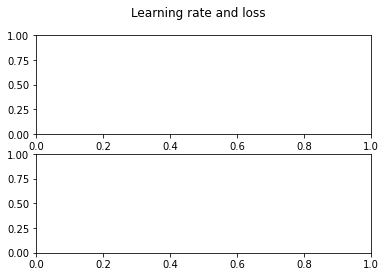

In [10]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

In [11]:
model.eval()
model.save_pretrained(saved_model_path)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


# RP evaluation

In [12]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight",
    "Bite",
    "Attack",
    "Go to store"
]

for rp in test_rps:
    start_prompt = '<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry happy "Hello, [player_name]."'
    print(f'{rp} -> {model_manager.say(start_prompt, rp)}')
    print(f'[sampled] {rp} -> {model_manager.say(start_prompt, rp, top_k = 50, top_p = 0.7)}')
    print("-" * 10)
    
print("Lowercase test")

for rp in test_rps:
    rp = rp[0].lower() + rp[1:]
    print(f'{rp} -> {model_manager.say("", rp)}')
    rp = rp.lower()
    print(f'{rp} -> {model_manager.say("", rp)}')
    print("-" * 10)

Visit Lorem -> park2<msg>Ry normal "Hey [player_name]!"<|endoftext|>
[sampled] Visit Lorem -> park2<msg>Ry normal "Hey [player_name]! How are you?"<|endoftext|>
----------
Meet with Lorem -> park2<msg>Ry normal "Hey [player_name]!"<|endoftext|>
[sampled] Meet with Lorem -> park2<msg>Ry normal "Hey [player_name]! How are you?"<|endoftext|>
----------
Visit Adine -> adineapt<msg>Ad normal "Hey [player_name]!"<|endoftext|>
[sampled] Visit Adine -> adineapt<msg>Ad disappoint "Hey [player_name]!"<|endoftext|>
----------
Fight -> park2<msg>m "Remy barely avoids my attack and fell, but managed to get up and quickly punch me in the face, a soaring pain quickly came over my face"<|endoftext|>
[sampled] Fight -> park2<msg>m "Remy barely avoids my attack and fell, but managed to get up and quickly punch me in the face, a soaring pain quickly came over my face"<|endoftext|>
----------
Bite -> park2<msg>Ry angry "Holy shit!"<|endoftext|>
[sampled] Bite -> park2<msg>Ry angry "Holy shit!"<|endoftext|

In [13]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry happy "Hello, [player_name]."', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad normal "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
    ('<p><msg>Nm "Ah, nice. I like it here."', "Can you swim?"),
]

def prompt_test(model_manager, do_sample_test = True):
    for (past, prompt) in prompts:
        print(f"Prompt: {prompt}")
        reply = model_manager.say(past, prompt)
        print(f"Reply: {reply}")
        if do_sample_test:
            reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
            print(f"Reply [sampled]: {reply}")
        print("-" * 10)
        
prompt_test(model_manager)

Prompt: How are you?
Reply: park2<msg>Ry normal "Hey [player_name]!"<|endoftext|>
Reply [sampled]: park2<msg>Ry normal "I'm OK. You can go for some beer."<p><msg>c "You're good to go."<d><scn>park2<msg>Ry normal "Oh, thank you for everything."<p><msg>c "No problem."<d><scn>park2<
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>Ad normal "I think he's ugly."<|endoftext|>
Reply [sampled]: park2<msg>Ad normal "I think he's cute."<|endoftext|>
----------
Prompt: Oh my god, Adine. What is this?
Reply: black<msg>Ad giggle "It's a long story for another time. I'm not even going to tell it to you yet."<p><msg>c "I know it's not supposed to be a story, but to tell it to me is the hardest thing for me."<d><scn>black<msg>Ad giggle "Well, it's not like
Reply [sampled]: park2<msg>m "I pulled my nose out of my eyes later. They'd been watching me from above."<d><scn>park2<msg>Ry shy "Did you see that? Out of his reach."<p><msg>c "He wasn't even your friend. He was the one to blame for